## Unzipping our dataset from the google drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

# Download latest version
# plant_disease_path = kagglehub.dataset_download("emmarex/plantdisease")
# plantify_dr_path = kagglehub.dataset_download("lavaman151/plantifydr-dataset")

!rm -rf '/content/drive/Shareddrives/ECS_170_Version2/Tomato_Dataset_Splitted_V3'

# !cp -r "/content/drive/Shareddrives/ECS_170/Tomato_Dataset_Splitted_V3" "/content/drive/Shareddrives/ECS_170_Version2/Tomato_Dataset_Splitted_V3"

#!ls -l '/content/drive/MyDrive/ECS_170/data/raw'
!ls -l '/content/drive/Shareddrives/ECS_170_Version2/Tomato_Dataset_Splitted_V3.zip'

# unzip datasets
!unzip '/content/drive/Shareddrives/ECS_170_Version2/Tomato_Dataset_Splitted_V3.zip' -d '/content/drive/Shareddrives/ECS_170_Version2'

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import os
import shutil
import cv2
import sys
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from google.colab import drive

from PIL import Image
from tqdm import tqdm

import numpy as np
import matplotlib as plt

import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torch.cuda.amp import autocast, GradScaler

# Enabling cude for training our CNN models
torch.backends.cudnn.benchmark = True

drive.mount('/content/drive')

!pip install optuna

# Copying the dataset into the local content drive
!cp -r "/content/drive/Shareddrives/ECS_170/Tomato_Dataset_Splitted_V3" "/content/dataset"

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.5 MB/s eta 0:00:00


## CNN Model

In [ ]:
from ast import mod
#Needs work
#referenced - https://medium.com/@myringoleMLGOD/simple-convolutional-neural-network-cnn-for-dummies-in-pytorch-a-step-by-step-guide-6f4109f6df80
#	          - https://medium.com/@kritiikaaa/convolution-neural-networks-guide-for-your-first-cnn-project-7ea56f7f6960
#           - https://www.geeksforgeeks.org/deep-learning/how-to-handle-overfitting-in-pytorch-models-using-early-stopping/
#           - https://www.geeksforgeeks.org/deep-learning/hyperparameter-tuning-with-optuna-in-pytorch/
# Formal dataset definition

# !ls -l '/content/drive/MyDrive/ECS_170/data/processed/merged_data'
import os
import shutil
import cv2
import sys
from pathlib import Path
import torch
print("Torch version:", torch.__version__)
print("Torch location:", torch.__file__)
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from tqdm import tqdm

import numpy as np

# For hyperparameter tuning
import optuna
import torch.optim as optim

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.cuda.amp import GradScaler, autocast

# CNN definition
class plantCNN(nn.Module):
    def __init__(self, hidden_size=128):
        super(plantCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        # self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        # self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.dropout = nn.Dropout(p=0.15)
        self.fc2 = nn.Linear(
            128,
            10
        )  # Healthy, Bacterial spot, Early blight, Late blight, Leaf Mold, Mosaic virus, Septoria leaf spot, Spider mites, Target Spot, Yellow Leaf Curl Virus

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))

        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        # x = self.pool(self.relu(self.conv1(x)))
        # x = self.pool(self.relu(self.conv2(x)))
        # x = self.pool(self.relu(self.conv3(x)))
        # x = self.flatten(x)
        # x = self.relu(self.fc1(x))
        # x = self.fc2(x)
        return x

# Creating a amp obtimizer to convert the 32 bit float to 16 bit float for faster computation in A100 GPU's
ampscaler = GradScaler(enabled=torch.cuda.is_available())
# Set up training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
# Training and validation loops
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in tqdm(loader, desc="Training"):
        # imgs, labels = imgs.to(device), labels.to(device)
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        optimizer.zero_grad()

        # A100 gpu Amp optimiser
        with autocast(enabled=torch.cuda.is_available()):
          outputs = model(imgs)
          loss = criterion(outputs, labels)

        ampscaler.scale(loss).backward()
        ampscaler.step(optimizer)
        ampscaler.update()

        # Regular Non A100 gpu
        # outputs = model(imgs)
        # loss = criterion(outputs, labels)
        # loss.backward()
        # optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
    acc = 100 * correct / total
    return running_loss / len(loader), acc

def eval_epoch(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validation"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    acc = 100 * correct / total
    return running_loss / len(loader), acc

# Block for hyperparameterized tuning
def objective(trial):
    learning_rate = trial.suggest_float('lr', 1e-4, 1e-1, log=True)
    hidden_size = trial.suggest_int('hidden_size', 128, 512)
    batch_size = trial.suggest_categorical('batch_size', [16,32,64])
    optimizers = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "SGD", "RMSprop", "Adagrad", "Adadelta", "NAdam"])
    model = plantCNN(hidden_size=hidden_size).to(device)

    if optimizers == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizers == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    elif optimizers == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizers == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optimizers ==  "Adagrad":
        optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)
    elif optimizers == "Adadelta":
        optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
    elif optimizers == "NAdam":
        optimizer = optim.NAdam(model.parameters(), lr=learning_rate)

    train_transform = transforms.Compose([
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.RandomRotation(degrees=10),
                                    transforms.ColorJitter(brightness=0.10, contrast=0.10),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5], [0.5])
                                ])
    general_transform = transforms.Compose([
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5], [0.5])
                                ])
    loader_train = DataLoader(
        datasets.ImageFolder('/content/dataset/train', transform=train_transform),
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    loader_val = DataLoader(
        datasets.ImageFolder('/content/dataset/val', transform=general_transform),
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    EPOCHS = 5
    for epoch in range(EPOCHS):
        train_epoch(model, loader_train, optimizer, criterion)
        val_loss, val_acc = eval_epoch(model, loader_val, criterion)

        # Sending the report to optuna
        trial.report(val_acc, epoch)
        if trial.should_prune():
          raise optuna.exceptions.TrialPruned()
    return val_acc

# Load the dataset
# data_root = "Tomato_Dataset_Splitted_V4/"
data_root = "/content/dataset"

train_transform = transforms.Compose([
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.RandomRotation(degrees=10),
                                    transforms.ColorJitter(brightness=0.10, contrast=0.10),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5], [0.5])
                                ])

val_transform = transforms.Compose([
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5], [0.5])
                                ])

train_data = ImageFolder(os.path.join(data_root, "train"), transform=train_transform)
val_data = ImageFolder(os.path.join(data_root, "val"), transform=val_transform)
test_data = ImageFolder(os.path.join(data_root, "test"), transform=val_transform)

# Hyperparameters tuning
hyperParams = optuna.create_study(direction="maximize")
hyperParams.optimize(objective, n_trials=15)

print("Best hyperparameters:", hyperParams.best_params)
print("Best validation accuracy:", hyperParams.best_value)

best_parameters = hyperParams.best_params

# Storing the best hyper parameter results into a variabels
best_learning_rate = best_parameters["lr"]
best_hidden_size = best_parameters["hidden_size"]
best_batch_size = best_parameters["batch_size"]
best_optimizer = best_parameters["optimizer"]

train_loader = DataLoader(
                        train_data, batch_size=best_batch_size, shuffle=True,
                        num_workers=4, pin_memory=True
                    )
val_loader = DataLoader(
                        val_data, batch_size=best_batch_size, shuffle=False,
                        num_workers=4, pin_memory=True
                    )
test_loader = DataLoader(
                        test_data, batch_size=best_batch_size, shuffle=False,
                        num_workers=4, pin_memory=True
                    )

# Setting the maximum amount to epochs to detect early stopping
epochs = 50
stop_epoch = 0

model = plantCNN(hidden_size=best_hidden_size).to(device)

# optimizer = optim.Adam(model.parameters(), lr=best_learning_rate)


if best_optimizer == "Adam":
  optimizer = optim.Adam(model.parameters(), lr=best_learning_rate)
elif best_optimizer == "AdamW":
  optimizer = optim.AdamW(model.parameters(), lr=best_learning_rate)
elif best_optimizer == "SGD":
  optimizer = optim.SGD(model.parameters(), lr=best_learning_rate)
elif best_optimizer == "RMSprop":
  optimizer = optim.RMSprop(model.parameters(), lr=best_learning_rate)
elif best_optimizer ==  "Adagrad":
  optimizer = optim.Adagrad(model.parameters(), lr=best_learning_rate)
elif best_optimizer == "Adadelta":
  optimizer = optim.Adadelta(model.parameters(), lr=best_learning_rate)
elif best_optimizer == "NAdam":
  optimizer = optim.NAdam(model.parameters(), lr=best_learning_rate)

# Function to implement the early stopping in the algorithm
class earlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model_state = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        # improvement means LOWER val_loss
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def restore_best(self, model):
        model.load_state_dict(self.best_model_state)

train_loss = 0
train_acc = 0
val_loss = 0
val_acc = 0

# Loading all the parameters in arrays for plot generations
train_acc_arr = []
train_loss_arr = []
val_acc_arr = []
val_loss_arr = []

early_stopping = earlyStopping()
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion)
    print(f"\nEpoch [{epoch+1}/{epochs}]")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%\n")
    train_acc_arr.append(train_acc)
    train_loss_arr.append(train_loss)
    val_acc_arr.append(val_acc)
    val_loss_arr.append(val_loss)
    # Checking for early stopping
    early_stopping(val_loss, model)
    stop_epoch = epoch + 1
    if early_stopping.early_stop:
      # Recovering the best model
      early_stopping.restore_best(model)
      os.makedirs("models/", exist_ok=True)
      torch.save({
          "model_state": model.state_dict(),
          "train_acc_arr": train_acc_arr,
          "val_acc_arr": val_acc_arr,
          "train_loss_arr": train_loss_arr,
          "val_loss_arr": val_loss_arr,
      }, "/content/drive/Shareddrives/ECS_170/models/plant_health_cnn_version4.pth")
      print("Model Early Stopped")
      break
    elif (epoch+1) == epochs:
      early_stopping.restore_best(model)
      os.makedirs("models/", exist_ok=True)
      torch.save({
          "model_state": model.state_dict(),
          "train_acc_arr": train_acc_arr,
          "val_acc_arr": val_acc_arr,
          "train_loss_arr": train_loss_arr,
          "val_loss_arr": val_loss_arr,
      }, "/content/drive/Shareddrives/ECS_170/models/plant_health_cnn_version4.pth")
      print("Model Trained")

Torch version: 2.9.0+cu126
Torch location: /usr/local/lib/python3.12/dist-packages/torch/__init__.py


/tmp/ipython-input-1644640978.py:93: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  ampscaler = GradScaler(enabled=torch.cuda.is_available())
[I 2025-12-06 08:15:07,206] A new study created in memory with name: no-name-d7bc22b8-b90c-4836-93b1-89f83b08fbb4
Training:   0%|          | 0/1268 [00:00<?, ?it/s]/tmp/ipython-input-1644640978.py:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
Validation: 100%|██████████| 272/272 [00:01<00:00, 155.82it/s]
[I 2025-12-06 08:16:34,455] Trial 0 finished with value: 83.16444035006909 and parameters: {'lr': 0.0005653134521414415, 'hidden_size': 482, 'batch_size': 32, 'optimizer': 'AdamW'}. Best is trial 0 with value: 83.16444035006909.
Validation: 100%|██████████| 272/272 [00:01<00:00, 155.75it/s]
[I 2025-12-06 08:17:49,386] Trial 1 finished

Best hyperparameters: {'lr': 0.00012318638348597687, 'hidden_size': 135, 'batch_size': 64, 'optimizer': 'NAdam'}
Best validation accuracy: 86.87240902809765


Validation: 100%|██████████| 136/136 [00:01<00:00, 81.40it/s]



Epoch [1/50]
Train Loss: 1.1188 | Train Acc: 62.17%
Val Loss:   0.7249 | Val Acc:   76.09%



Validation: 100%|██████████| 136/136 [00:01<00:00, 79.50it/s]



Epoch [2/50]
Train Loss: 0.7277 | Train Acc: 75.35%
Val Loss:   0.5418 | Val Acc:   83.04%



Validation: 100%|██████████| 136/136 [00:01<00:00, 77.93it/s]



Epoch [3/50]
Train Loss: 0.6033 | Train Acc: 79.43%
Val Loss:   0.4596 | Val Acc:   85.09%



Validation: 100%|██████████| 136/136 [00:01<00:00, 77.38it/s]



Epoch [4/50]
Train Loss: 0.5330 | Train Acc: 81.72%
Val Loss:   0.4215 | Val Acc:   86.61%



Validation: 100%|██████████| 136/136 [00:01<00:00, 79.51it/s]



Epoch [5/50]
Train Loss: 0.4837 | Train Acc: 83.36%
Val Loss:   0.3910 | Val Acc:   87.00%



Validation: 100%|██████████| 136/136 [00:01<00:00, 80.41it/s]



Epoch [6/50]
Train Loss: 0.4403 | Train Acc: 84.97%
Val Loss:   0.3425 | Val Acc:   88.91%



Validation: 100%|██████████| 136/136 [00:01<00:00, 80.15it/s]



Epoch [7/50]
Train Loss: 0.4091 | Train Acc: 85.96%
Val Loss:   0.3450 | Val Acc:   88.48%



Validation: 100%|██████████| 136/136 [00:01<00:00, 80.72it/s]



Epoch [8/50]
Train Loss: 0.3805 | Train Acc: 87.00%
Val Loss:   0.2949 | Val Acc:   90.76%



Validation: 100%|██████████| 136/136 [00:01<00:00, 79.22it/s]



Epoch [9/50]
Train Loss: 0.3591 | Train Acc: 87.49%
Val Loss:   0.3322 | Val Acc:   89.35%



Validation: 100%|██████████| 136/136 [00:01<00:00, 81.41it/s]



Epoch [10/50]
Train Loss: 0.3340 | Train Acc: 88.42%
Val Loss:   0.2794 | Val Acc:   90.75%



Validation: 100%|██████████| 136/136 [00:01<00:00, 81.18it/s]



Epoch [11/50]
Train Loss: 0.3182 | Train Acc: 89.15%
Val Loss:   0.2448 | Val Acc:   92.33%



Validation: 100%|██████████| 136/136 [00:01<00:00, 81.17it/s]



Epoch [12/50]
Train Loss: 0.3028 | Train Acc: 89.53%
Val Loss:   0.2548 | Val Acc:   91.62%



Validation: 100%|██████████| 136/136 [00:01<00:00, 81.50it/s]



Epoch [13/50]
Train Loss: 0.2913 | Train Acc: 89.94%
Val Loss:   0.2355 | Val Acc:   92.42%



Validation: 100%|██████████| 136/136 [00:01<00:00, 80.62it/s]



Epoch [14/50]
Train Loss: 0.2714 | Train Acc: 90.49%
Val Loss:   0.2260 | Val Acc:   92.89%



Validation: 100%|██████████| 136/136 [00:01<00:00, 79.00it/s]



Epoch [15/50]
Train Loss: 0.2610 | Train Acc: 91.00%
Val Loss:   0.2113 | Val Acc:   93.48%



Validation: 100%|██████████| 136/136 [00:01<00:00, 80.21it/s]



Epoch [16/50]
Train Loss: 0.2511 | Train Acc: 91.33%
Val Loss:   0.2174 | Val Acc:   93.10%



Validation: 100%|██████████| 136/136 [00:01<00:00, 80.97it/s]



Epoch [17/50]
Train Loss: 0.2340 | Train Acc: 91.92%
Val Loss:   0.1920 | Val Acc:   94.07%



Validation: 100%|██████████| 136/136 [00:01<00:00, 82.85it/s]



Epoch [18/50]
Train Loss: 0.2310 | Train Acc: 92.05%
Val Loss:   0.1853 | Val Acc:   94.22%



Validation: 100%|██████████| 136/136 [00:01<00:00, 82.04it/s]



Epoch [19/50]
Train Loss: 0.2249 | Train Acc: 92.20%
Val Loss:   0.1870 | Val Acc:   94.23%



Validation: 100%|██████████| 136/136 [00:01<00:00, 80.92it/s]



Epoch [20/50]
Train Loss: 0.2133 | Train Acc: 92.61%
Val Loss:   0.1747 | Val Acc:   94.85%



Validation: 100%|██████████| 136/136 [00:01<00:00, 77.83it/s]



Epoch [21/50]
Train Loss: 0.2051 | Train Acc: 92.84%
Val Loss:   0.1884 | Val Acc:   93.92%



Validation: 100%|██████████| 136/136 [00:01<00:00, 78.69it/s]



Epoch [22/50]
Train Loss: 0.2044 | Train Acc: 92.86%
Val Loss:   0.1735 | Val Acc:   94.62%



Validation: 100%|██████████| 136/136 [00:01<00:00, 79.94it/s]



Epoch [23/50]
Train Loss: 0.1952 | Train Acc: 93.33%
Val Loss:   0.1582 | Val Acc:   95.28%



Validation: 100%|██████████| 136/136 [00:01<00:00, 80.85it/s]



Epoch [24/50]
Train Loss: 0.1839 | Train Acc: 93.60%
Val Loss:   0.1588 | Val Acc:   95.58%



Validation: 100%|██████████| 136/136 [00:01<00:00, 81.81it/s]



Epoch [25/50]
Train Loss: 0.1848 | Train Acc: 93.54%
Val Loss:   0.1696 | Val Acc:   94.80%



Validation: 100%|██████████| 136/136 [00:01<00:00, 82.97it/s]



Epoch [26/50]
Train Loss: 0.1724 | Train Acc: 94.01%
Val Loss:   0.1486 | Val Acc:   95.45%



Validation: 100%|██████████| 136/136 [00:01<00:00, 79.27it/s]



Epoch [27/50]
Train Loss: 0.1717 | Train Acc: 93.89%
Val Loss:   0.1459 | Val Acc:   95.82%



Validation: 100%|██████████| 136/136 [00:01<00:00, 77.22it/s]



Epoch [28/50]
Train Loss: 0.1620 | Train Acc: 94.36%
Val Loss:   0.1517 | Val Acc:   95.54%



Validation: 100%|██████████| 136/136 [00:01<00:00, 77.94it/s]



Epoch [29/50]
Train Loss: 0.1642 | Train Acc: 94.21%
Val Loss:   0.1403 | Val Acc:   95.84%



Validation: 100%|██████████| 136/136 [00:01<00:00, 80.66it/s]



Epoch [30/50]
Train Loss: 0.1580 | Train Acc: 94.43%
Val Loss:   0.1317 | Val Acc:   96.10%



Validation: 100%|██████████| 136/136 [00:01<00:00, 80.07it/s]



Epoch [31/50]
Train Loss: 0.1558 | Train Acc: 94.61%
Val Loss:   0.1291 | Val Acc:   96.27%



Validation: 100%|██████████| 136/136 [00:01<00:00, 81.62it/s]



Epoch [32/50]
Train Loss: 0.1504 | Train Acc: 94.77%
Val Loss:   0.1340 | Val Acc:   95.97%



Validation: 100%|██████████| 136/136 [00:01<00:00, 80.57it/s]



Epoch [33/50]
Train Loss: 0.1426 | Train Acc: 95.00%
Val Loss:   0.1254 | Val Acc:   96.56%



Validation: 100%|██████████| 136/136 [00:01<00:00, 81.01it/s]



Epoch [34/50]
Train Loss: 0.1397 | Train Acc: 95.10%
Val Loss:   0.1368 | Val Acc:   95.84%



Validation: 100%|██████████| 136/136 [00:01<00:00, 81.44it/s]



Epoch [35/50]
Train Loss: 0.1361 | Train Acc: 95.08%
Val Loss:   0.1443 | Val Acc:   95.85%



Validation: 100%|██████████| 136/136 [00:01<00:00, 82.66it/s]



Epoch [36/50]
Train Loss: 0.1417 | Train Acc: 95.09%
Val Loss:   0.1223 | Val Acc:   96.57%



Validation: 100%|██████████| 136/136 [00:01<00:00, 77.97it/s]



Epoch [37/50]
Train Loss: 0.1317 | Train Acc: 95.34%
Val Loss:   0.1283 | Val Acc:   96.03%



Validation: 100%|██████████| 136/136 [00:01<00:00, 81.33it/s]



Epoch [38/50]
Train Loss: 0.1286 | Train Acc: 95.54%
Val Loss:   0.1142 | Val Acc:   96.63%



Validation: 100%|██████████| 136/136 [00:01<00:00, 80.46it/s]



Epoch [39/50]
Train Loss: 0.1290 | Train Acc: 95.49%
Val Loss:   0.1074 | Val Acc:   97.13%



Validation: 100%|██████████| 136/136 [00:01<00:00, 77.74it/s]



Epoch [40/50]
Train Loss: 0.1234 | Train Acc: 95.71%
Val Loss:   0.1152 | Val Acc:   96.65%



Validation: 100%|██████████| 136/136 [00:01<00:00, 80.30it/s]



Epoch [41/50]
Train Loss: 0.1246 | Train Acc: 95.55%
Val Loss:   0.1143 | Val Acc:   96.74%



Validation: 100%|██████████| 136/136 [00:01<00:00, 79.30it/s]



Epoch [42/50]
Train Loss: 0.1139 | Train Acc: 96.00%
Val Loss:   0.1102 | Val Acc:   96.94%



Validation: 100%|██████████| 136/136 [00:01<00:00, 81.16it/s]



Epoch [43/50]
Train Loss: 0.1175 | Train Acc: 95.89%
Val Loss:   0.1165 | Val Acc:   96.91%



Validation: 100%|██████████| 136/136 [00:01<00:00, 80.24it/s]



Epoch [44/50]
Train Loss: 0.1161 | Train Acc: 95.90%
Val Loss:   0.1119 | Val Acc:   97.12%

Model Early Stopped


## Evaluation Metrics/Code

Torch version: 2.9.0+cu126
Torch location: /usr/local/lib/python3.12/dist-packages/torch/__init__.py
Mounted at /content/drive


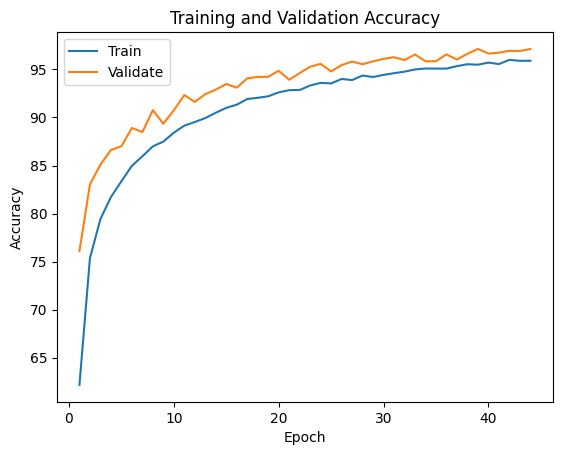

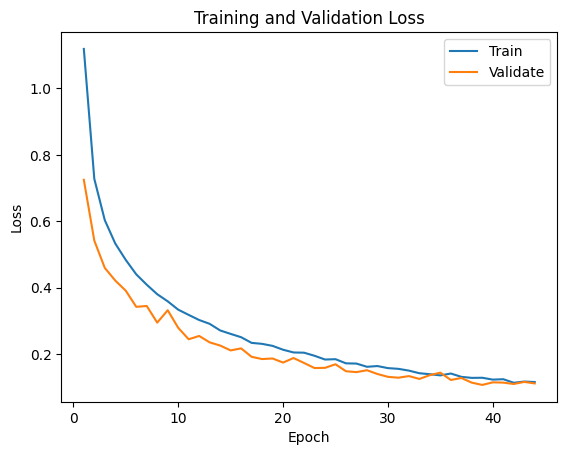

In [ ]:
## Generating training, validation accuracy and loss for the algorithm
import torch
print("Torch version:", torch.__version__)
print("Torch location:", torch.__file__)
import torch.nn as nn
import torch.nn.functional as F
import os
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive')

# CNN definition
class plantCNN(nn.Module):
    def __init__(self, hidden_size=128):
        super(plantCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        # self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        # self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.dropout = nn.Dropout(p=0.15)
        self.fc2 = nn.Linear(
            128,
            10
        )  # Healthy, Bacterial spot, Early blight, Late blight, Leaf Mold, Mosaic virus, Septoria leaf spot, Spider mites, Target Spot, Yellow Leaf Curl Virus

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))

        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        # x = self.pool(self.relu(self.conv1(x)))
        # x = self.pool(self.relu(self.conv2(x)))
        # x = self.pool(self.relu(self.conv3(x)))
        # x = self.flatten(x)
        # x = self.relu(self.fc1(x))
        # x = self.fc2(x)
        return x

model = plantCNN()
model_checkpoint = torch.load("/content/drive/Shareddrives/ECS_170/models/plant_health_cnn_version4.pth")
model.load_state_dict(model_checkpoint["model_state"])

# Load the objects in an array
train_acc_arr = model_checkpoint["train_acc_arr"]
val_acc_arr = model_checkpoint["val_acc_arr"]
train_loss_arr = model_checkpoint["train_loss_arr"]
val_loss_arr = model_checkpoint["val_loss_arr"]

model.eval()

# Creates graphs for the train accuracy vs val accuracy and train loss vs val loss
plt.plot(range(1, 1+len(train_acc_arr)), train_acc_arr, label="Train")
plt.plot(range(1, 1+len(val_acc_arr)), val_acc_arr, label="Validate")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
os.makedirs("/content/drive/Shareddrives/ECS_170_Version2/eval_metrics", exist_ok=True)
plt.savefig(os.path.join("/content/drive/Shareddrives/ECS_170_Version2/eval_metrics", "accuracy_plot.png"))
plt.show()

plt.plot(range(1, 1+len(train_loss_arr)), train_loss_arr, label="Train")
plt.plot(range(1, 1+len(val_acc_arr)), val_loss_arr, label="Validate")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig(os.path.join("/content/drive/Shareddrives/ECS_170_Version2/eval_metrics", "loss_plot.png"))
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model loaded successfully!


Test:: 100%|██████████| 132/132 [24:16<00:00, 11.04s/it]


classification report:
                               precision    recall  f1-score   support

        Tomato Bacterial spot       0.99      0.98      0.98       972
          Tomato Early blight       0.94      0.93      0.94       671
               Tomato Healthy       0.99      0.98      0.98       869
           Tomato Late blight       0.96      0.97      0.96       934
             Tomato Leaf Mold       0.94      0.95      0.95       651
          Tomato Mosaic virus       0.97      0.97      0.97       454
    Tomato Septoria leaf spot       0.94      0.94      0.94       599
          Tomato Spider mites       0.98      0.99      0.98       829
           Tomato Target Spot       0.97      0.97      0.97       763
Tomato Yellow Leaf Curl Virus       0.99      0.99      0.99      1662

                     accuracy                           0.97      8404
                    macro avg       0.97      0.97      0.97      8404
                 weighted avg       0.97      0.97  

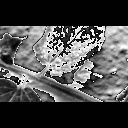

model guessed the label Tomato Leaf Mold when the real label was Tomato Bacterial spot



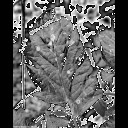

model guessed the label Tomato Septoria leaf spot when the real label was Tomato Bacterial spot



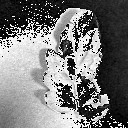

model guessed the label Tomato Late blight when the real label was Tomato Bacterial spot



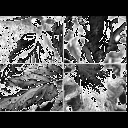

model guessed the label Tomato Yellow Leaf Curl Virus when the real label was Tomato Bacterial spot



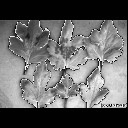

model guessed the label Tomato Early blight when the real label was Tomato Bacterial spot



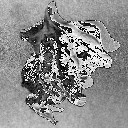

model guessed the label Tomato Target Spot when the real label was Tomato Early blight



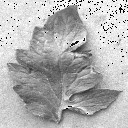

model guessed the label Tomato Bacterial spot when the real label was Tomato Early blight



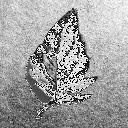

model guessed the label Tomato Spider mites when the real label was Tomato Early blight



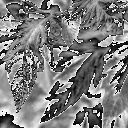

model guessed the label Tomato Mosaic virus when the real label was Tomato Late blight



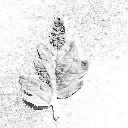

model guessed the label Tomato Healthy when the real label was Tomato Mosaic virus



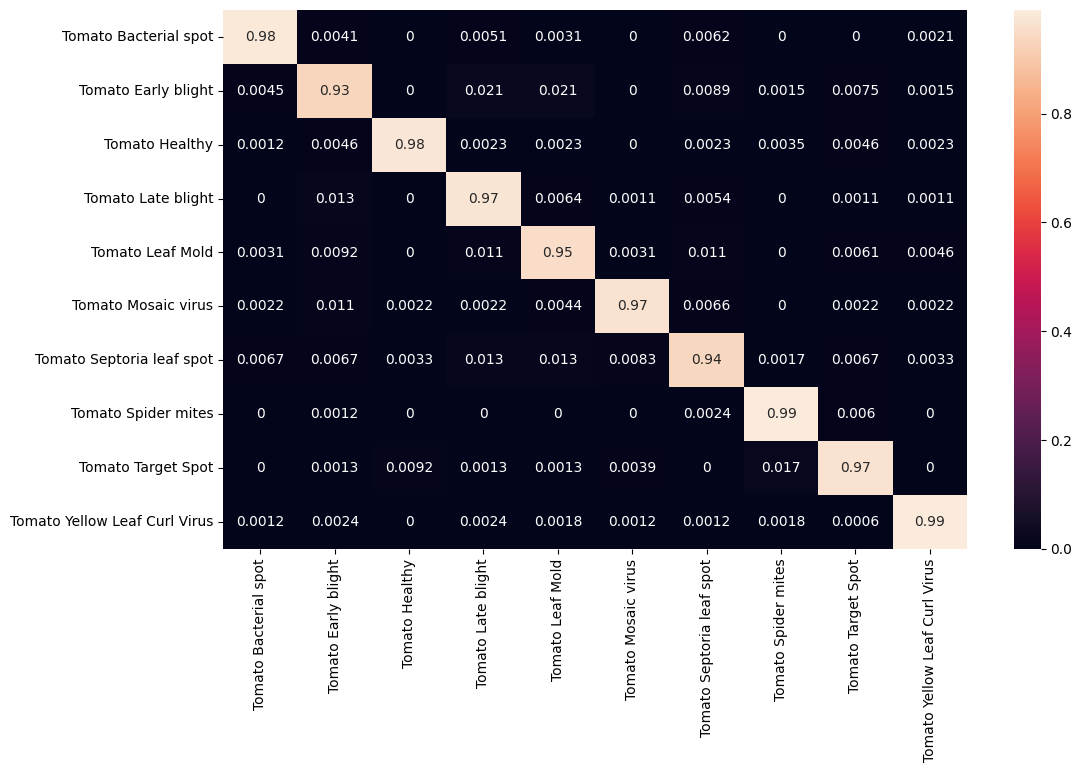

In [ ]:
# TODO reformat so there is less reused code
# Other than the copy line I think all the imports can be moved up to the top import section
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd
import torch
from google.colab import drive
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import os
import torch.optim as optim
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
from PIL import Image

import numpy as np
import matplotlib as plt

# TBH we might wanna put constants in the imports too
data_root = "/content/drive/Shareddrives/ECS_170_Version2/Tomato_Dataset_Splitted_V3/"
drive.mount('/content/drive')

# CNN definition
class plantCNN(nn.Module):
    def __init__(self, hidden_size=128):
        super(plantCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        # self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        # self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.dropout = nn.Dropout(p=0.15)
        self.fc2 = nn.Linear(
            128,
            10
        )  # Healthy, Bacterial spot, Early blight, Late blight, Leaf Mold, Mosaic virus, Septoria leaf spot, Spider mites, Target Spot, Yellow Leaf Curl Virus

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))

        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        # x = self.pool(self.relu(self.conv1(x)))
        # x = self.pool(self.relu(self.conv2(x)))
        # x = self.pool(self.relu(self.conv3(x)))
        # x = self.flatten(x)
        # x = self.relu(self.fc1(x))
        # x = self.fc2(x)
        return x

## Evaluation code goes here

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def test_epoch(model, loader, criterion):
    model.eval()
    y_pred = []
    y_true = []
    incorrect_lbl = []
    incorrect_img = []
    real_lbl = []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Test:"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            # A100 gpu Amp optimiser
            # with autocast():
            #   outputs = model(imgs)
            #   loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            # brings the predictions back to normal probability distribution then converts them to a numpy array
            y_pred.extend(preds.data.cpu().numpy())
            y_true.extend(labels.data.cpu().numpy())
            incorrect_img.extend(imgs[preds != labels].cpu().numpy())
            incorrect_lbl.extend(preds[preds != labels].cpu().numpy())
            real_lbl.extend(labels[preds != labels].cpu().numpy())

    return y_pred, y_true, incorrect_img, incorrect_lbl, real_lbl

# Basic code to load the model
model_load = torch.load("/content/drive/Shareddrives/ECS_170/models/plant_health_cnn_version4.pth")
model = plantCNN().to(device)   # same architecture
model.load_state_dict(model_load["model_state"])
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # ensures single channel
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_data = ImageFolder(os.path.join(data_root, "test"), transform=transform)

classes = test_data.classes

test_loader = DataLoader(
                        test_data, batch_size=64, shuffle=False,
                        num_workers=4, pin_memory=True
                    )
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# model.eval()
print("Model loaded successfully!")
os.makedirs("/content/drive/Shareddrives/ECS_170_Version2/eval_metrics", exist_ok=True)
# Confusion matrix code based on this tutorial
y_pred, y_true, incorrect_img, incorrect_lbl, labels_arr  = test_epoch(model, test_loader, criterion)
cf_matrix = confusion_matrix(y_true, y_pred)
# converts the confusion matrix to probabilities
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.pyplot.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.pyplot.savefig('output.png')

cl_report = classification_report(y_true, y_pred, target_names=classes)
print("classification report:")
print(cl_report)

# prints incorrect output
incorrect_img = np.array(incorrect_img).squeeze(1)
lbl_displayed = [0] * 10
for i in range(len(incorrect_lbl)):
    # if we haven't displayed an incorrect item for this label yet
    if lbl_displayed[incorrect_lbl[i]]!= 1:
        img_arr = incorrect_img[i]
        img = Image.fromarray((img_arr * 255).astype(np.uint8)) # unnormalizes the image
        display(img)
        print(f"model guessed the label {classes[incorrect_lbl[i]]} when the real label was {classes[labels_arr[i]]}\n")
        # img.save("/content/drive/Shareddrives/ECS_170_Version2/eval_metrics" / (classes[incorrect_lbl[i]]+"_labeled_as_"+classes[labels_arr[i]]+".png"))
        lbl_displayed[incorrect_lbl[i]]=1
    elif (lbl_displayed == ([1] * 10)):
        break
